# Step 0: Setup Google Drive + Install Module

In [2]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Step 1: Import Module

In [41]:
from tqdm import tqdm
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
# from xgboost import XGBClassifier
# from sklearn.neighbors import KNeighborsClassifier

# Step 2: Import and Prepare Data from CSV

In [5]:
path = "/content/drive/MyDrive/utau-csv"
q = []
for i in tqdm(os.listdir(path)):
  q.append(pd.read_csv(os.path.join(path, i)))

100%|██████████| 843/843 [00:33<00:00, 25.43it/s]


In [6]:
all_df = [i.drop(["start_time", "start_pitch"], axis=1) for i in q]

In [7]:
connect = all_df[0]
for i in all_df[1:]:
  connect = connect.append(i)
connect

,song_id,length,note_num,is_rest,pby_pattern
0,0,10290,60,True,0
1,0,480,60,False,11
2,0,480,62,False,7
3,0,240,62,False,0
4,0,240,65,False,35
...,...,...,...,...,...
635,844,480,48,True,0
636,844,480,48,True,0
637,844,480,48,True,0
638,844,480,48,True,0


In [8]:
data_prepare = connect.copy()
col = ["is_rest"]
for i in col:
    data_prepare[i] = data_prepare[i].astype("category").cat.codes

data_prepare["song_id2"] = data_prepare["song_id"].shift(-1)
data_prepare["length2"] = data_prepare["length"].shift(-1)
data_prepare["note_num2"] = data_prepare["note_num"].shift(-1)
data_prepare["is_rest2"] = data_prepare["is_rest"].shift(-1)
idx = data_prepare["song_id"] != data_prepare["song_id2"]
data_prepare.loc[idx, "length2"] = 0
data_prepare.loc[idx, "note_num2"] = 0
data_prepare.loc[idx, "is_rest2"] = 0
data_prepare = data_prepare.fillna(0)
data_prepare = data_prepare[data_prepare.is_rest2 == 0]
data_prepare["length2"] = data_prepare["length2"].astype(int)
data_prepare["note_num2"] = data_prepare["note_num2"].astype(int)

# data_prepare = data_prepare[data_prepare.pby_pattern != 0]
# data_prepare = data_prepare[data_prepare.pby_pattern != 1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
x = data_prepare[["length", "note_num", "is_rest", "length2", "note_num2"]]
y = data_prepare["pby_pattern"]

In [10]:
 data_prepare[["length", "note_num", "is_rest", "length2", "note_num2"]]

,length,note_num,is_rest,length2,note_num2
0,10290,60,1,480,60
1,480,60,0,480,62
2,480,62,0,240,62
3,240,62,0,240,65
4,240,65,0,240,65
...,...,...,...,...,...
630,480,54,0,480,53
631,480,53,0,480,52
632,480,52,0,1620,51
638,480,48,1,480,60


In [11]:
data_prepare["pby_pattern"]

0       0
1      11
2       7
3       0
4      35
       ..
630    55
631    51
632    35
638     0
639     0
Name: pby_pattern, Length: 268439, dtype: int64

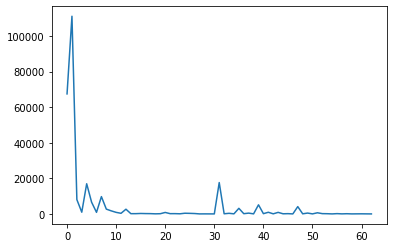

In [12]:
pt, count = np.unique(y, return_counts=True)
plt.plot(pt, count)

In [13]:
list(zip(pt,count))

[(0, 67442),
 (1, 111072),
 (2, 8051),
 (3, 970),
 (4, 16946),
 (5, 6599),
 (6, 885),
 (7, 9725),
 (8, 2698),
 (9, 1721),
 (10, 877),
 (11, 344),
 (12, 2649),
 (13, 141),
 (14, 146),
 (15, 252),
 (16, 187),
 (17, 159),
 (18, 52),
 (19, 119),
 (20, 823),
 (21, 150),
 (22, 156),
 (23, 74),
 (24, 384),
 (25, 316),
 (26, 219),
 (27, 10),
 (28, 26),
 (29, 14),
 (30, 3),
 (31, 17620),
 (32, 82),
 (33, 341),
 (34, 50),
 (35, 3145),
 (36, 133),
 (37, 447),
 (38, 33),
 (39, 5119),
 (40, 142),
 (41, 923),
 (42, 53),
 (43, 868),
 (44, 76),
 (45, 147),
 (46, 9),
 (47, 4103),
 (48, 60),
 (49, 478),
 (50, 24),
 (51, 642),
 (52, 162),
 (53, 120),
 (54, 8),
 (55, 161),
 (56, 27),
 (57, 113),
 (58, 13),
 (59, 40),
 (60, 58),
 (61, 30),
 (62, 2)]

# Step 3: Testing Baseline

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1234)

In [36]:
def port_baseline_score(x, y):
  xt = x.copy()
  xt = x_test.copy()
  xt.loc[xt["note_num"] >= xt["note_num2"], "pby_pattern"] = 1
  xt.loc[xt["note_num"] < xt["note_num2"], "pby_pattern"] = 2
  return accuracy_score(xt["pby_pattern"].to_numpy(), y)

In [40]:
print(port_baseline_score(x_test, y_test))

0.26958724482193414


# Step 4: Train with RandomForest

In [26]:
rf = RandomForestClassifier()

In [27]:
rf.fit(x_train, y_train)
print("done")

done


In [43]:
print("rf score:", rf.score(x_test, y_test))
print("port baseline score:", port_baseline_score(x_test, y_test))

rf score: 0.6103114289971688
port baseline score: 0.26958724482193414


In [44]:
print(classification_report(rf.predict(x_test), y_test))

              precision    recall  f1-score   support

           0       0.71      0.89      0.79     13328
           1       0.91      0.56      0.70     45447
           2       0.14      0.45      0.21       615
           3       0.07      0.25      0.11        64
           4       0.15      0.43      0.22      1419
           5       0.09      0.35      0.15       437
           6       0.16      0.38      0.22        92
           7       0.20      0.46      0.28      1062
           8       0.15      0.41      0.22       239
           9       0.13      0.48      0.20       120
          10       0.14      0.39      0.20        67
          11       0.12      0.33      0.18        30
          12       0.15      0.37      0.21       254
          13       0.12      0.36      0.18        14
          14       0.19      0.28      0.23        25
          15       0.21      0.36      0.27        33
          16       0.08      0.24      0.11        17
          17       0.14    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Notes: Using LogisticRegression model

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [32]:
sc = StandardScaler()
lr = LogisticRegression()

lr.fit(sc.fit_transform(x_test), y_test)
print("done")

done


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [39]:
print("lr score:", lr.score(sc.transform(x_test), y_test))

lr score: 0.5562360303978543


In [34]:
np.unique(lr.predict(sc.transform(x_test)), return_counts=True)

(array([ 0,  1,  4,  7, 30]), array([ 9931, 57140,     2,    36,     1]))

In [ ]:
np.unique(rf.predict(x_test), return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 59, 60, 61]),
 array([13587, 45305,   632,    56,  1379,   444,    80,  1014,   247,
          112,    63,    30,   247,    13,    27,    34,    16,    13,
            7,    10,    87,    12,    21,     3,    52,    40,    29,
            1,  2158,     9,    40,     4,   306,    10,    34,     4,
          310,    23,   107,     3,    49,     9,    12,     1,   275,
            8,    77,     2,    25,    29,    10,     2,     7,     6,
           12,     1,    13,     3]))

In [ ]:
lr.coef_[0]

array([ 0.89615101,  0.17243007,  2.64328129, -0.19448669, -0.15574255])

In [ ]:
lr.coef_[1]

array([-2.71564095e+00,  6.94343957e-03,  5.94777851e-01,  2.34514749e-03,
        1.38405953e-01])

# Step 5: Getting it back to UST files

In [ ]:
def base_pby_pattern_to_mode2pitch(note1, note2, length1, length2, tempo, pby_pattern, q1=0.2, q2=0.5):
  """Baseline Mode2Pitch generator, do not use in production"""
  if not pby_pattern:
    return [0, 0], [], []
  mspb = (1 / (tempo / 480)) * (60*1000) # milliseconds per beat
  l1_ms, l2_ms = (length1 / 480) * mspb, (length2 / 480) * mspb
  base = [2**i - 1 for i in range(6)]
  subtract = [pby_pattern-i for i in base if pby_pattern-i >= 0]
  subtracted_pitch_length = len(subtract)-1
  subtracted_pitch = [int(i) for i in list(f"{subtract[-1]:0b}")]
  subtracted_pitch = [0 for i in range(subtracted_pitch_length - len(subtracted_pitch))] + subtracted_pitch
  start_time, start_pitch = -abs((l1_ms) * q1), (note1 - note2) * 10 # PBS
  total_ms = l1_ms * q1 + l2_ms * q2
  pbw = [total_ms / subtracted_pitch_length] * subtracted_pitch_length
  up_count = len([i for i in subtracted_pitch if base == 1])
  down_count = len([i for i in subtracted_pitch if base == 0])
  
  tp = [-1 if i == 0 else 1 for i in subtracted_pitch]
  tc = [sum(tp[:i+1]) for i in range(subtracted_pitch_length)]
  # print(tp, tc)
  c = max(1, abs(max(tc) - min(tc)))
  sh = ((note2 - note1) / c) * 10
  if note2 - note1 >= 0:
    pby = [start_pitch+j*sh for j in tc]
  else:
    pby = [start_pitch-j*sh for j in tc]
  pby = [i-pby[0] for i in pby]
  return [start_time, start_pitch], pbw, pby

base_pby_pattern_to_mode2pitch(63, 60, 240, 480, 480*120, 1)

([-50.0, 30], [300.0], [0.0])